In [61]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

In [62]:
class Line:
    
    def __init__(self, pt1, pt2):
        self.pt1 = pt1
        self.pt2 = pt2
        self.__split_points()
        self.__compute_hvType()
        self.__compute_id_coord()
        
    def __split_points(self):
        self.x1, self.y1 = self.pt1
        self.x2, self.y2 = self.pt2
    
    def __compute_hvType(self):
        x_dist, y_dist = abs(self.x2 - self.x1), abs(self.y2 - self.y1)
        self.hv_type = 'v' if x_dist < y_dist else 'h'
        
    def __compute_id_coord(self):
        self.id_coord = np.mean([self.x1, self.x2]) if self.hv_type == 'v' else np.mean([self.y1, self.y2])
        self.id_coord = int(self.id_coord)
        
    def to_list(self):
        return self.x1, self.y1, self.x2, self.y2
    
        
def parse_object(obj):
    (x1, y1), (x2, y2) = obj['points']['exterior']
    return x1, y1, x2, y2
    
    
def load_json(fpath):
    lines = []
    objs = json.load(open(fpath, "r"))['objects']
    for obj in objs:
        if obj['geometryType'] == "line":
            x1, y1, x2, y2 = parse_object(obj)
            lines.append(Line(pt1=(x1, y1), pt2=(x2, y2)))
    return lines

In [63]:
ANN_DIR = "./annotations/Batch1/ds0/ann/"
IMG_DIR = "../download_from_drive/data/ProcessedO7/"

In [64]:
images_data_dict = {k: [] for k in ["img_key", "w", "h", "n_lines", "n_lines_v", "n_lines_h"]}

ann_files = [f for f in os.listdir(ANN_DIR) if f.endswith(".json")]
for ann_fn in ann_files:
    lines = load_json(fpath=os.path.join(ANN_DIR, ann_fn))
    images_data_dict['img_key'].append(ann_fn.split('.jpg.json')[0])
    images_data_dict['n_lines'].append(len(lines))
    h, w = cv2.imread(os.path.join(IMG_DIR, ann_fn.split('.json')[0])).shape[:2]
    images_data_dict['w'].append(w)
    images_data_dict['h'].append(h)
    vlines = [l for l in lines if l.hv_type == 'v']
    hlines = [l for l in lines if l.hv_type == 'h']
    images_data_dict["n_lines_v"].append(len(vlines))
    images_data_dict["n_lines_h"].append(len(hlines))

In [65]:
images_df = pd.DataFrame(images_data_dict)
display(images_df)

# for n_lines_v in images_df.n_lines_v.unique():
#     print("n_lines_v =", n_lines_v)
#     for _, row in images_df.query("n_lines_v == @n_lines_v").sample(10).iterrows():
#         img = cv2.imread(os.path.join(IMG_DIR, row.img_key + ".jpg"))
#         plt.figure(figsize=(12,12)), plt.imshow(img); plt.axis('off'); plt.show()
#     print("\n\n\n")

,img_key,w,h,n_lines,n_lines_v,n_lines_h
0,100849_O7_0240,1350,1970,14,4,10
1,100849_O7_0242,1370,1940,17,4,13
2,100849_O7_0244,1330,1950,14,4,10
3,10231_O7_0067,1370,1980,16,5,11
4,103445_O7_0206,1400,1980,21,5,16
...,...,...,...,...,...,...
246,90003_O7_0292,1340,1970,16,5,11
247,90003_O7_0294,1340,1940,18,5,13
248,91717_O7_0130,1390,1970,16,5,11
249,91717_O7_0132,1350,1950,18,5,13


In [201]:
N_LINES_V = 4
lines_data_dict = {k: [] for k in ["img_key", "hv", "id_coord"]}

df = images_df.query("n_lines_v == @N_LINES_V")
for _, row in df.iterrows():
    lines = load_json(fpath=os.path.join(ANN_DIR, row.img_key + ".jpg.json"))
    
    for line in lines:
        lines_data_dict["img_key"].append(row.img_key)
        lines_data_dict["hv"].append(line.hv_type)
        id_coord = line.id_coord / (row.w if line.hv_type == 'v' else row.h)
        lines_data_dict["id_coord"].append(round(id_coord, 2))

lines_df = pd.DataFrame(lines_data_dict)
lines_df

,img_key,hv,id_coord
0,100849_O7_0240,h,0.33
1,100849_O7_0240,h,0.39
2,100849_O7_0240,h,0.46
3,100849_O7_0240,h,0.53
4,100849_O7_0240,h,0.59
...,...,...,...
436,88728_O7_0334,h,0.93
437,88728_O7_0334,v,0.10
438,88728_O7_0334,v,0.16
439,88728_O7_0334,v,0.35


In [218]:
# keys = lines_df.img_key.unique()
# rnd_id1 = keys[np.random.randint(0, len(keys))]
# rnd_id2 = keys[np.random.randint(0, len(keys))]
# display(lines_df.query("hv == \"v\" and img_key == @rnd_id1").sort_values("id_coord"))
# display(lines_df.query("hv == \"v\" and img_key == @rnd_id2").sort_values("id_coord"))

,img_key,hv,id_coord
55,103445_O7_0208,v,0.11
56,103445_O7_0208,v,0.17
57,103445_O7_0208,v,0.35
58,103445_O7_0208,v,0.54


,img_key,hv,id_coord
299,64073_O7_0480,v,0.12
300,64073_O7_0480,v,0.17
301,64073_O7_0480,v,0.35
302,64073_O7_0480,v,0.53


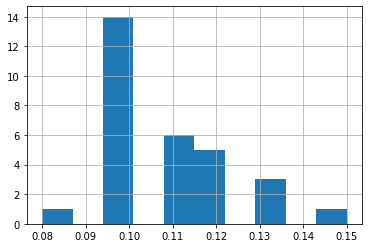

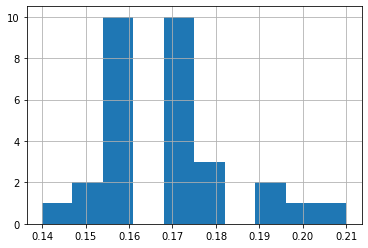

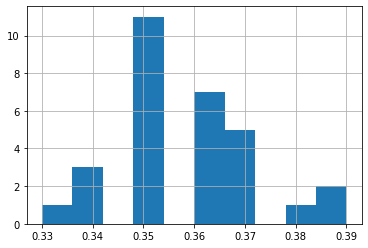

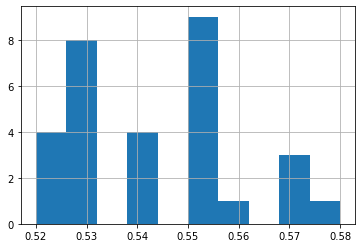

In [220]:
d = {i: [] for i in range(N_LINES_V)}

for img_key in lines_df.img_key.unique():
    df = lines_df.query("hv == \"v\" and img_key == @img_key").sort_values("id_coord")
    i = 0
    for _, row in df.iterrows():
        d[i].append(row.id_coord)
        i += 1

vlines_df = pd.DataFrame(d)
for i in range(N_LINES_V):
    vlines_df[i].hist()
    plt.show()